Initialization

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['seaborn-ticks', 'seaborn-talk'])
import cartopy.crs as ccrs
import cmocean

import logging
logging.basicConfig(level=logging.WARNING)

import xarray as xr
import pandas as pd
import numpy as np

import air_quality as aq
from air_quality.plot import usa_states_ax

from tqdm import tqdm, tqdm_notebook
tqdm_notebook()

/Users/daniel/anaconda/lib/python3.5/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime
/Users/daniel/anaconda/lib/python3.5/site-packages/matplotlib/ticker.py:1693: UserWarning: Steps argument should be a sequence of numbers
increasing from 1 to 10, inclusive. Behavior with
values outside this range is undefined, and will
raise a ValueError in future versions of mpl.
  warnings.warn('Steps argument should be a sequence of numbers\n'
Widget Javascript not detected.  It may not be installed or enabled properly.


0it [00:00, ?it/s]

Here we try to reproduce some of the broad strokes of the analysis by [Shen et al (2017)](http://dx.doi.org/10.5194/acp-17-4355-2017), for both Fernando's ensemble as well as Evan's simulations with GEOS-Chem.

# Ensemble Data Processing

We need to extract the data we're going to use from both Fernando's and Evan's ensemble. Because they use different models, each ensemble requires a slightly different approach. 

## Fernando's Ensemble

Fernando's raw ensemble output is saved in timeslice format, straight from the CESM. I whipped together a data processing pipeline to extract particular variables that we care about in timeseries format, and saved them to **svante11:/d0/darothen/IGSM-CAM-Chem**.

The following cell encodes the information from this experiment.

In [ ]:
from experiment import Experiment, Case
ROOT_DIR = "/net/fs11/d0/darothen/IGSM-CAM-Chem"
pols = Case("pol", "Emissions Policy", ["REF", "P37", "P45"])
css = Case("cs", "Climate Sensitivity", 
           # [20, 30, 45]
           [30, ]
)
ics = Case("ic", "Initial Conditions", [1, 2, 3, 4, 5])
decs = Case("dec", "Decadal Period",
            ["1980-2010", "2035-2065", "2085-2115"])
cases = pols, css, ics, decs

fgm_exp = Experiment("fgm_proc", cases, timeseries=True, data_dir=ROOT_DIR,
                     case_path="{pol}.CS{cs}.IC{ic}.{dec}",
                     output_prefix="{pol}.CS{cs}.IC{ic}.{dec}.", 
                     output_suffix=".monthly.nc", validate_data=False)
print(fgm_exp)

Define and load in the data fields that we need. This is really bringing up some edge cases in **Experiment** which I don't have the time or patience to solve in full right now, so this is going to be very hacky. At the end of this procedure, we'll have a `dict` with the relevant fields we need for this analysis, and then we can serialize all of this processed code to disk.

In [ ]:
data_fgm = {}
for key in ['TREFHT', 'RELHUM_SRF', 'PRECT', 'U_SRF', 'V_SRF', 'PM25']:
    print(key)
    data_fgm[key] = (
        # Load in each dataset, selecting just the field corresponding to 
        # the filename (only matters for PM25)
        fgm_exp.load(key, master=True, 
                     preprocess=lambda x, **kwargs: x[[key, ]],
                     load_kws=dict(chunks={'lat': 72, 'lon': 48}))
        # Manually decode CF 
        .pipe(xr.decode_cf)
        [key]
    )

Consolidate into a single dataset, and coerce to our preferred naming scheme.

Two operations - scaling the precipitation and rolling the grid - can take a very long time, so heads up!

In [ ]:
data_fgm_all = xr.Dataset()
data_fgm_all['PM25'] = data_fgm['PM25']
data_fgm_all['TEMP'] = data_fgm['TREFHT']
# # Precipitation here is in m/s, but we want mm/day
data_fgm_all['PRECIP'] = data_fgm['PRECT'] * 1000. * 3600. * 24
data_fgm_all['RH'] = data_fgm['RELHUM_SRF']
data_fgm_all['U'] = data_fgm['U_SRF']
data_fgm_all['V'] = data_fgm['V_SRF']

# Squeeze out extra lev and case dims
data_fgm_all = data_fgm_all.squeeze()

# Also need to shift lons since we're on [0, 360] right now, but would prefer [-180, 180]
# from darpy import shift_lons
# data_fgm_all = shift_lons(data_fgm_all)
# NOTE: We don't need to roll the longitudes into the correct, monotonic order
#       because we're ultimately going to subset the USA grid cells, which are all
#       negative values of lon.
# data_fgm_all = data_fgm_all.roll(lon=71)


## Evan's Ensemble

I originally processed Evan's ensemble output in a completely different way than Fernando's. However, it was still designed to be recorded in an **Experiment** which I previously serialized to disk.

In [ ]:
ec_exp = Experiment.from_yaml("ecouzo.climatepenalty.yml")
print(ec_exp)

It should be a little bit more straightforward to load this data, since Evan was not missing an outputs or experiments (it's a much smaller ensemble). The trick is just to get the right field names.

**DAO_FLDS**

These are all 2D fields.

- *TS*: surface air temperature (really 2m)
- *PREACC*: total precipitation at the ground
- *U10*: U-winds at 10m
- *V10*: V-winds at 10m

Relative humidity isn't contained here... instead, it's in the output tape **BXHGHT**. Unfortunately, Evan didn't save this field. We instead of access to the grid box heights (*BXHEIGHT*), air mass density (*AD*), and water vapor mixing ratio (*AVGW*). We could back out the relative humidity by computing grid cell volume (*BXHGHT* times the spatial area of each cell) and using *AD* and *AVGW*. Alternatively, we can just compute relative humidity following the definition:

$$RH = \frac{w}{w_s(p, T)} \approx \frac{e}{e_s}$$

where $w$ is the water vapor mixing ratio, $w_s(p, T)$ is the saturation water vapor mixing ratio, and $e$ is the vapor pressure of water vapor. We can estimate $e$ from $w$

$$e \approx \epsilon w p$$

where $\epsilon = R'/R_v \approx 0.622$ and $p$ is the atmospheric pressure. Then, 

$$e_s(T) = 6.122 \exp{\frac{17.67T}{T+243.5}}$$ where $T$ is the temperature in degrees C

Based on the output we have, we have to mix the two methods. We compute the partial pressure of water vapor by using the ideal gas law and  **AVGW**, **N_AIR**, and **TS**, then diving by $e_s(\mathrm{TS})$.

**2D Meteorology Fields**

In [ ]:
from functools import partial
ec_met_fields = ['DAO_FLDS__' + x for x in ['TS', 'PREACC', 'U10M', 'V10M']]

def _pp(ds, field, **kwargs):
    return ds[field].isel(lat=slice(1, -1)).squeeze()

data_ec = {}
for field in ec_met_fields:
    print(field)
    pp = partial(_pp, field=field)
    data_ec[field] = ec_exp.load(field, master=True, preprocess=pp,
                                 load_kws={'chunks': {'lon': 72, 'lat': 33}})
data_ec = xr.Dataset(data_ec)

**Relative Humidity**

In [ ]:
from functools import partial
ec_rh_fields = ['BXHGHT_S__' + x for x in ['N_AIR_', 'AVGW']]

def _pp(ds, field, **kwargs):
    return ds.isel(lev=0, lat=slice(1, -1))[field].squeeze()

data_rh = {}
for field in ec_rh_fields:
    print(field)
    pp = partial(_pp, field=field)
    _data = ec_exp.load(field, master=False, preprocess=pp,
                        load_kws={'chunks': {'lon': 72, 'lat': 33}})
    data_rh[field] = ec_exp.create_master(field, _data)
data_rh = xr.Dataset(data_rh)

Apply formulas and calculate

In [ ]:
Av = 6.023e23
e = data_rh['BXHGHT_S__N_AIR_'] * data_rh['BXHGHT_S__AVGW'] * data_ec['DAO_FLDS__TS'] / Av 
Tc = data_ec['DAO_FLDS__TS'] - 273.15
es = (6.112)*np.exp(17.67*Tc / (Tc + 243.5))

# e is in hPa, and es is in Pa, so we'll actually end up the *100 conversion 
# factor to get % implicitly
rh = e / es
rh.attrs.update({'long_name': 'Relative Humidity', 'units': '%'})
data_rh['RH'] = rh

**PM2.5**

Evan didn't include PM2.5 as a diagnostic output, so we can compute it using the [recommended formula](http://wiki.seas.harvard.edu/geos-chem/index.php/Particulate_matter_in_GEOS-Chem#PM2.5_diagnostic):

``` fortran
  ; Convert ppbv to ug/m3
  STP_P    = 1013.25
  STP_T    = 298.
  ppb_ugm3 = 1e6 / 8.314 * 100. * STP_P/STP_T *1e-9 

 ; Compute PM2.5
 PM25     = ( ( NH4         )       * ppb_ugm3 * 18 )
          + ( ( NIT         )       * ppb_ugm3 * 62 )
          + ( ( SO4         )       * ppb_ugm3 * 96 )
          + ( ( BCPI + BCPO )       * ppb_ugm3 * 12 )
          + ( ( OCPI + OCPO ) * 2.1 * ppb_ugm3 * 12 )
          + ( ( DST1 + DST2 )       * ppb_ugm3 * 29 )
```

In [ ]:
from functools import partial
ec_pm_fields = ['IJ_AVG_S__' + x for x in ['NH4', 'NIT', 'SO4', 'BCPI', 'BCPO',
                                           'OCPI', 'OCPO', 'DST1', 'DST2']]

# Factors to convert from ppbv to ug/m3
stp_p = 1013.25 # hPa
stp_t = 298. # K
ppb_ugm3 = 1e6 / 8.314 * 100. * stp_p/stp_t * 1e-9

def _pp(ds, field, **kwargs):
    da = ds.isel(lev=0, lat=slice(1, -1))[field].squeeze()
    return da * ppb_ugm3

data_pm = {}
for field in ec_pm_fields:
    print(field)
    pp = partial(_pp, field=field)
    _data = ec_exp.load(field, master=False, preprocess=pp,
                        load_kws={'chunks': {'lon': 72, 'lat': 33}})
    data_pm[field] = ec_exp.create_master(field, _data)
data_pm = xr.Dataset(data_pm)

In [ ]:
# Multiply each species by their molecular weight
nh4 = data_pm['IJ_AVG_S__NH4'] * 18.
nit = data_pm['IJ_AVG_S__NIT'] * 62.
so4 = data_pm['IJ_AVG_S__SO4'] * 96.
bcpi = data_pm['IJ_AVG_S__BCPI'] * 12.
bcpo = data_pm['IJ_AVG_S__BCPO'] * 12.
ocpi = data_pm['IJ_AVG_S__OCPI'] * 12.
ocpo = data_pm['IJ_AVG_S__OCPO'] * 12.
dst1 = data_pm['IJ_AVG_S__DST1'] * 29.
dst2 = data_pm['IJ_AVG_S__DST2'] * 29.

pm25 = nh4 + nit + so4 + bcpi + bcpo + 2.1*(ocpi + ocpo) + dst1 + dst2
pm25.attrs.update({'long_name': 'Particulate matter, > 2.5 micron', 
                   'units': 'ug/m3'})
data_pm['PM25'] = pm25

Finally, we consolidate into a single dataset.

In [ ]:
data_ec_all = xr.Dataset()
data_ec_all['PM25'] = data_pm['PM25']
data_ec_all['TEMP'] = data_ec['DAO_FLDS__TS']
data_ec_all['PRECIP'] = data_ec['DAO_FLDS__PREACC']
data_ec_all['RH'] = data_rh['RH']
data_ec_all['U'] = data_ec['DAO_FLDS__U10M']
data_ec_all['V'] = data_ec['DAO_FLDS__V10M']

## Update Attributes

Correct the attributes on both of our datasets.

In [ ]:
from collections import namedtuple
from itertools import product

import datetime
a = datetime.datetime.now()
now = a.strftime("%b %d, %Y %H:%M")

attr_tup = namedtuple("attr", ["field", "long_name", "units"])
attrs = [
    attr_tup("PM25", "Particulate matter >2.5 micron", "ug/m3"),
    attr_tup('TEMP', "Temperature", "K"),
    attr_tup("PRECIP", "Precipitation", "mm/day"),
    attr_tup("RH", "Relative humidity", "%"),
    attr_tup("U", "Zonal winds", "m/s"),
    attr_tup("V", "Meridional winds", "m/s"),
]

for ds in [data_ec_all, data_fgm_all]:
    for attr in attrs:
        ds[attr.field].attrs.update({
            'long_name': attr.long_name, 'units': attr.units
        })
    ds.attrs.update({
       "History": "Generated by 09_lu_shen_reproduction.ipynb ({})\n"
                  .format(now)
    }) 

## USA Subset

Lu Shen subsets the data he cares about to a ~350 km box surrounding a gridpoint of interest. For the sake of simplicity, let's subset the entire dataset to the Continental US, give or take a few degrees (and maybe a gridbox or two). This will significantly reduce the size of the data, and allow us to synchronize it to disk very easily.


In [ ]:
from darpy import shift_lons

# This should cover *all* of CONUS
lon_lims = -125, -66
lat_lims = 22, 52

# Roll here so we can use the same longitude limits for both datasets
data_fgm_usa = (
    data_fgm_all
    .sel(lat=slice(*lat_lims), 
         lon=slice(360+lon_lims[0], 360+lon_lims[1]))
    .pipe(shift_lons)
)
data_ec_usa = data_ec_all.sel(lon=slice(*lon_lims), lat=slice(*lat_lims))

### Cache USA Data

At this point, the datasets we've processed are very small, so we can cache them for exchange between svante and my laptop. The data will be saved in `data/lu_2017/{field}.all_cases.usa_subset` where **{field}** is the name of the variable we've saved.

In [ ]:
data_fgm_usa.to_netcdf("../data/processed/lu_2017/fgm.all_cases.usa_subset.nc")
data_ec_usa.to_netcdf("../data/processed/lu_2017/ec.all_cases.usa_subset.nc")

## Detrend

Detrend the data by removing the 5-year moving average from the monthly values. These operations could take a pretty long time, so we'll cache them on disk when we're done.

Upon digging into Lu's scripts, his description in his paper is **NOT** accurate. It's a bit tricky what he's done here, but in his `functions.R` he has two moving averages - one that uses an equal weighting, and one that weights by [1, 2, 3, 2, 1]. So issue (a) is that the weights are wrong, and issue (b) is that he's using *centered* averages.

In [ ]:
def _detrend(ds, center=True, min_periods=2):
    means = ds.rolling(time=5, center=center, min_periods=min_periods).mean()
    return (ds - means)

print("FGM")
data_fgm_usa_detrend = data_fgm_usa.groupby('time.month').apply(_detrend)
print("EC")
data_ec_usa_detrend = data_ec_usa.groupby('time.month').apply(_detrend)

### Cache detrended USA data

In [ ]:
data_fgm_usa_detrend.to_netcdf("../data/processed/lu_2017/fgm.all_cases.usa_subset.detrended.nc")
data_ec_usa_detrend.to_netcdf("../data/processed/lu_2017/ec.all_cases.usa_subset.detrended.nc")

# Process Observational data

In [ ]:
import os

pth = "/Users/daniel/Downloads/shen_2017/Data/"
ncep_pth = os.path.join(pth, 'NCEP')

# Process NCEP meteorology
ncep_data = []
for fld in ['air', 'rhum', 'uwnd', 'vwnd']:
    fn = os.path.join(ncep_pth, fld+'.mon.mean.nc')
    print(fn)
    ncep_data.append(xr.open_dataset(fn))
ncep_ds = (
    xr.auto_combine(ncep_data)
      .rename({'rhum': 'RH', 'uwnd': 'U', 'vwnd': 'V',
               'air': 'TEMP'})

)

# Process derived PM25
pm25_fn = os.path.join(pth, "PM_region.nc")
pm25 = xr.open_dataset(pm25_fn)
years = pm25.year.astype('int')
months = pm25.month.astype('int')
days = pm25.day.astype('int')
dates = [pd.Timestamp(year, month, day) 
         for year, month, day in zip(years.values, months.values, days.values)]
pm25['time'].values = dates

# Helper function to only take mean of cells where there are at least a
# certain number of valid values (9 by default) in the timeseries
def nan_mean(ds, n=9, field='PM25', dim='time'):
    n_valid = ds.count(dim)[field] > n
    return ds.where(n_valid).mean(dim)

# # Compute monthly means manually, then reconstruct
all_monthly_means = []
for year in np.unique(pm25.year.astype('int').values):
    # Select year
    year_data = pm25.where(pm25.year == year, drop=True).drop('month')
    # Apply to calculate monthly means 
    monthly_means = year_data.groupby(year_data['time.month']).apply(nan_mean)
    # Coerce datetime stamps
    timestamps = [pd.Timestamp(year, m, 1) for m in monthly_means.month.values]
    monthly_means = monthly_means.rename({'month': 'time'}).assign(time=timestamps)
    all_monthly_means.append(monthly_means)
pm25 = xr.concat(all_monthly_means, 'time')[['PM25', ]]
pm25['lon'].values = pm25['lon'].values + 360

# # Save to disk
pm25.to_netcdf(pm25_fn+".processed", encoding={'time': {'units': 'days since 1990-01-01'}})

# Process derived preciptiation
precip_fn = os.path.join(pth, "monthly-prate_1999-2013.nc")
precip = xr.open_dataset(precip_fn, decode_times=False)
precip['time'].values = pd.date_range("1999/1/1", periods=180, freq='MS')

data_obs = xr.auto_combine([ncep_ds, pm25, precip])

data_obs = data_obs.sel(time=slice("1999/1/1", "2013/12/31"))

In [ ]:
data_obs.to_netcdf("../data/processed/lu_2017/obs.nc")

## Extract USA subset

In [ ]:
from darpy import shift_lons

# This should cover *all* of CONUS
lon_lims = -125, -66
lat_lims = 22, 52

# Roll here so we can use the same longitude limits for both datasets
data_obs_usa = (
    data_obs
    .sel(lat=slice(*lat_lims), 
         lon=slice(360+lon_lims[0], 360+lon_lims[1]))
    .pipe(shift_lons)
)

data_obs_usa.to_netcdf("../data/processed/lu_2017/obs.usa_subset.nc")

## Detrend

In [ ]:
def _detrend(ds, center=True, min_periods=2):
    means = ds.rolling(time=5, center=center, min_periods=min_periods).mean()
    return (ds - means)

# data_obs_usa_detrend = data_obs_usa.groupby('time.month').apply(_detrend)
# data_obs_usa_detrend.to_netcdf("../data/processed/lu_2017/obs.usa_subset.detrended.nc")

# Load Cached data

In [2]:
data_fgm_usa = xr.open_dataset("../data/processed/lu_2017/fgm.all_cases.usa_subset.nc")
data_ec_usa = xr.open_dataset("../data/processed/lu_2017/ec.all_cases.usa_subset.nc")

data_fgm_usa_detrend = xr.open_dataset("../data/processed/lu_2017/fgm.all_cases.usa_subset.detrended.nc").drop('month')
data_ec_usa_detrend = xr.open_dataset("../data/processed/lu_2017/ec.all_cases.usa_subset.detrended.nc").drop('month')

data_obs = xr.open_dataset("../data/processed/lu_2017/obs.nc")
data_obs_usa = xr.open_dataset("../data/processed/lu_2017/obs.usa_subset.nc")
data_obs_usa_detrend = xr.open_dataset("../data/processed/lu_2017/obs.usa_subset.detrended.nc")

---

# Synoptic Circulation Factors

Lu's analysis involves looking at the correlations between different meteorological factors indicative of the larger-scale circulation. In particular, he looks at temperature, relative humidity, precipitation, zonal winds, and meridional winds over the Southeastern United States, particularly for averages of the May-June-July monthly mean concentrations at each grid cell.

We can first visualize what this data looks like. Let's look at PM25 for the reference case.

In [ ]:
from air_quality.plot import usa_states_ax, STATE_PROJ
from darpy.utilities import shift_lons
from darpy.plot import get_figsize
import cmocean
import cartopy.crs as ccrs

nrows, ncols = 1, 3
size, aspect = 4.25, 1.25
figsize = get_figsize(nrows, ncols, size, aspect)
fig, axs = plt.subplots(nrows, ncols, figsize=figsize,
                        subplot_kw=dict(projection=STATE_PROJ))

vmin, vmax = 0, 30
cmap = cmocean.cm.haline
cmap_kws = dict(vmin=vmin, vmax=vmax, levels=31, cmap=cmap, add_colorbar=False)

# ax = usa_states_ax(facecolor='None', lw=1.5)
to_plot_fgm = data_fgm_usa['PM25'].sel(pol='REF', ic=1, dec='1980-2010').mean('time')
im = to_plot_fgm.plot.imshow(ax=axs[0], transform=ccrs.PlateCarree(), **cmap_kws)
axs[0].set_title("CESM/CAM-Chem")

# ax = usa_states_ax(facecolor='None', lw=1.5)
to_plot_ec = data_ec_usa['PM25'].sel(emis='2006', met='PD').mean('time')
im = to_plot_ec.plot.imshow(ax=axs[1], transform=ccrs.PlateCarree(), **cmap_kws)
axs[1].set_title("GEOS-Chem")

# ax = usa_states_ax(facecolor='None', lw=1.5)
to_plot_ec = data_obs_usa['PM25'].mean('time')
im = to_plot_ec.plot.imshow(ax=axs[2], transform=ccrs.PlateCarree(), **cmap_kws)
axs[2].set_title("Observations")

for ax in axs:
    _ = usa_states_ax(ax=ax, facecolor='None', lw=1.5)
    ax.set_aspect('auto', 'box-forced')

cb = plt.colorbar(im, ax=list(axs), 
                  orientation='horizontal', shrink=0.8, fraction=0.075, use_gridspec=True)
cb.set_label("PM$_{2.5}$ ug/m3")

plt.savefig("../figs/lu_2017/annual_mean.pm25.comparison.pdf", 
            transparent=True, bbox_inches='tight')


## Spatial Correlation

We now have essentially the same data as Lu et al use to construct the synoptic circulation factors. The next step, then, is to re-produce the entire analysis.

To demonstrate what is going on, Lu et al compute pair-wise correlations bewtween each grid cell and a specific location, arbitarily chosen to be in Georgia at 82.5W, 32.5N. The correlations are computed between PM25 and each of the other fields.

We first reproduce this analysis by computing the pair-wise correlations for the Georgia location. However, we'll use the entire 150 year dataset in the reference scenario.

Now we average over May-June-July using the masking/resampling API. We use the de-trended data for purposes of computing the spatial correlations and synoptic circulation factors.

In [59]:
import calendar

MNTHS = [5, 6, 7,]
mnths_str = ''.join([calendar.month_abbr[m][0] for m in MNTHS])
print(mnths_str)

def isin(da, vals):
    """ Determine whether or not values in a given DataArray belong
    to a set of permissible values. """
    return da.to_series().isin(vals).to_xarray()

def calc_months_mean(dataset, months):
    ds = dataset.copy()
    # valid_months = ds['time.month'].to_pandas().isin(MNTHS)
    # return ds.where(valid_months.to_xarray()).resample('AS', 'time', how='mean')
    return ds.where(isin(ds['time.month'], months)).resample('AS', 'time', 'mean')

def sel_months(dataset, months):
    ds = dataset.copy()
    return ds.where(isin(ds['time.month'], months), drop=True)

data_fgm_usa_mjj = data_fgm_usa_detrend.apply(calc_months_mean, months=MNTHS)
data_ec_usa_mjj = data_ec_usa_detrend.apply(calc_months_mean, months=MNTHS)
data_obs_usa_mjj = data_obs_usa_detrend.apply(calc_months_mean, months=MNTHS)

data_fgm_usa_mjj_sel = data_fgm_usa_detrend.apply(sel_months, months=MNTHS)
data_ec_usa_mjj_sel = data_ec_usa_detrend.apply(sel_months, months=MNTHS)
data_obs_usa_mjj_sel = data_obs_usa_detrend.apply(sel_months, months=MNTHS)

MJJ


### Select Case

For the Georgia example, compute the reference timeseries at our chosen location to regress against the other timeseries.

This code will generalize to an arbitrary site or ensemble member. Be sure to run it, so that the resulting output datasets and figures will be consistent.

In [16]:
from air_quality.models.shen2017 import _detrend_moving_avg, _isin

# site_lon=360-82.5
site_lon = -82.5
site_lat=32.5
site_name = "Georgia"

# # site_lon=360-71
# site_lon = -71
# site_lat=42
# site_name = "Boston"

# # site_lon=360-85.76
# site_lon = -85.76
# site_lat=38.3
# site_name = "Louisville"

# case = 'ec' # 'fgm' # 'obs'
case = 'obs'

if case == 'ec':
    emis = '2006'
    met = 'PD'
    data_subset = data_ec_usa_mjj_sel.sel(emis=emis, met=met)
    full_case = "{}.{}.{}".format(case, emis, met)
elif case == 'fgm':
    pol = 'REF'
    dec = '1980-2010'
    data_subset = data_fgm_usa_mjj_sel.sel(pol=pol, dec=dec)
    full_case = "{}.{}.{}".format(case, pol, dec)
elif case == 'obs':
#     data_subset = data_obs_usa_mjj_sel.copy().drop('month')
    from darpy import shift_lons, detrend as ddetrend

    data_subset = xr.open_dataset("../data/processed/lu_2017/obs.usa_subset.nc")
    data_subset = data_subset.sel(time=_isin(data_subset['time.month'], [5, 6, 7]))
#     for v in data_subset.data_vars:
#         data_subset[v] = (
#             data_subset[v]
#             .groupby(data_subset['time.month'])
#             .apply(ddetrend)
#             .drop('month')
#         )
    data_subset = (
        data_subset
        .groupby(data_subset['time.month'])
        .apply(_detrend_moving_avg, center=True, min_periods=1)
        .drop('month')
    )
#     data_subset = shift_lons(data_subset).roll(lon=71)
    full_case = "obs"
    
# Clip the data to a smaller window around the cell of interest
# dlon, dlat = 20, 15
dlon, dlat = 16, 10
nlon, nlat =  6, 4
lon_lo, lon_hi = site_lon-dlon, site_lon+dlon
lat_lo, lat_hi = site_lat-dlat, site_lat+dlat
data_subset = data_subset.sel(lat=slice(lat_lo, lat_hi),
                              lon=slice(lon_lo, lon_hi))

# Demean/Scale timeseries in each grid cell
# note, though, that we don't apply this operation to the PM25 data.
pm25 = data_subset['PM25'].copy()
_m = data_subset.mean('time')
_s = data_subset.std('time')
print(_m)
data_subset = (data_subset - _m)/_s
# data_subset['PM25'] = pm25

print(full_case)
data_ref = data_subset.sel(lon=site_lon, lat=site_lat, method='nearest')
pm25_ref = data_ref['PM25']      
print(len(pm25_ref))

print('Lon ->', float(pm25_ref.lon), site_lon)
print('Lat ->', float(pm25_ref.lat), site_lat)
print(data_subset.dims)


<xarray.Dataset>
Dimensions:  (lat: 9, lon: 13)
Coordinates:
  * lat      (lat) float32 22.5 25.0 27.5 30.0 32.5 35.0 37.5 40.0 42.5
  * lon      (lon) float32 -97.5 -95.0 -92.5 -90.0 -87.5 -85.0 -82.5 -80.0 ...
Data variables:
    RH       (lat, lon) float64 -0.03267 0.05935 0.0005075 -0.09869 -0.09017 ...
    U        (lat, lon) float64 -0.02273 -0.03713 -0.06173 -0.06408 -0.05887 ...
    TEMP     (lat, lon) float64 0.01389 0.001972 0.01562 0.02844 0.0266 ...
    V        (lat, lon) float64 -0.02041 0.01784 0.04356 0.03475 0.003285 ...
    PRECIP   (lat, lon) float32 nan nan nan nan nan nan nan nan nan nan nan ...
    PM25     (lat, lon) float32 nan nan nan nan nan nan nan nan nan nan nan ...
obs
45
Lon -> -82.5 -82.5
Lat -> 32.5 32.5
Frozen(SortedKeysDict(OrderedDict([('lat', 9), ('lon', 13), ('time', 45)])))


(-1, 46)

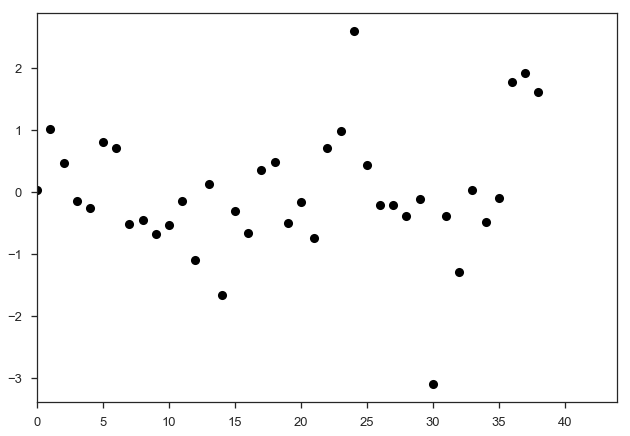

In [61]:
pm25_ref.to_dataframe().reset_index()['PM25'].plot(lw=0, marker='o', color='k')

ax.set_ylim(-4.2, 4.2)
ax.set_xlim(-1, 46)

(-1, 46)

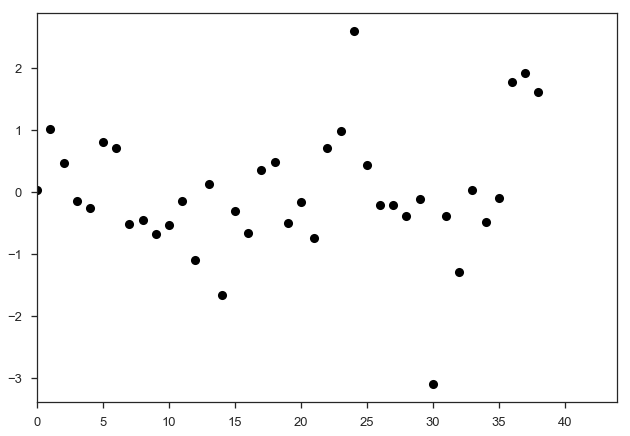

In [62]:
pm25_ref.to_dataframe().reset_index()['PM25'].plot(lw=0, marker='o', color='k')

ax.set_ylim(-4.2, 4.2)
ax.set_xlim(-1, 46)

The easiset way to perform the correlation analysis is to iterate over our 2D lat-lon grid as 1D vector of independent timeseries. This means we have to ravel the data as a numpy array behind the scenes in our dataset. Because we only have a ~15x~24 grid of points, this is really fast to do. However, if we were to extend this analysis to the next step (pairwise correlations for every single grid cell as a reference) then some more thought would be necessary.

The EC and FGM ensembles differ in that the FGM ensemble has multiple realizations of each timeseries (**ic**). We need to take that into account when we stack our data, so we add an option to our helper method to control how the *x* and *y* data get stacked.

In [17]:
from scipy.stats import pearsonr, spearmanr 
r_func = pearsonr # spearmanr
# r_func = spearmanr

x_stack_ec = x_stack_obs = dict(cell=['lat', 'lon'])
x_stack_fgm = dict(cell=['lat', 'lon'], all_time=['ic', 'time'])

y_stack_ec = y_stack_obs = {}
y_stack_fgm = dict(all_time=['ic', 'time'])

def _clean_xy(x, y):
    df = pd.DataFrame({'x': x, 'y': y}).dropna()
    return df.x.values, df.y.values
    

def calc_correlations(f, ds, y, x_stack, y_stack):
    """ Compute pairwise correlations between a reference timeseries (y) and
    the timeseries for field f at each grid-cell in a given dataset ds. """
    x_ds = (
        ds
        .squeeze()
        .stack(**x_stack)
    )
    x_da = x_ds[f]
    y_da = y.stack(**y_stack)

    # Coerce X and y data to numpy arrays
    # NOTE: May need to transpose (or not) 'x' depending on lat/lon ordering
    x = x_da.data.T
    y = y_da.data

    # Calculate correlations
    rr = np.asarray([r_func(*_clean_xy(x[i], y)) for i in range(len(x))])
    rs, ps = rr[:,0], rr[:, 1]
#     rr = np.asarray([np.corrcoef(x[i], y) for i in range(len(x))])
#     print(rr.shape)
#     rs, ps = rr[:, 0], rr[:, 1]
    # plt.plot(corrs[:-1, -1])
    # plt.plot(rs)

    # Add correlation coefficient and p-values to original dataset, and use
    # the embedded logic to re-shape to the original 2D lat-lon grid
    x_ds['r'] = (['cell', ], rs)
    x_ds['p'] = (['cell', ], ps)
    x_ds = x_ds.unstack('cell')
    
    return x_ds[['r', 'p']]

In [18]:
x_stack = x_stack_ec if case in ['ec', 'obs'] else x_stack_fgm
y_stack = y_stack_ec if case in ['ec', 'obs'] else y_stack_fgm

pt_corrs = xr.Dataset()
for var in data_subset.data_vars:
    print(var)
    results = calc_correlations(var, data_subset, pm25_ref,
                                x_stack=x_stack, y_stack=y_stack)
    pt_corrs[var+"_r"] = results['r']
    pt_corrs[var+"_p"] = results['p']

RH
U
TEMP
V
PRECIP


/Users/daniel/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:3024: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/Users/daniel/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/Users/daniel/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:3025: RuntimeWarning: Mean of empty slice.
  my = y.mean()
/Users/daniel/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:3029: RuntimeWarning: invalid value encountered in float_scalars
  r = r_num / r_den


PM25


### Plot) Map of $r$ for each grid cell vs reference

TEMP
RH
PRECIP
U
V
PM25


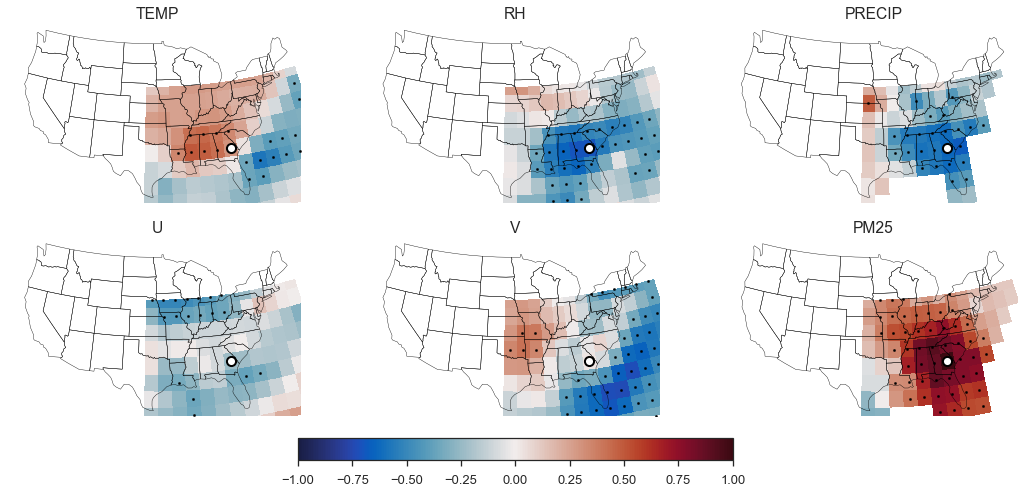

In [65]:
from air_quality.plot import add_usa_states, STATE_PROJ
from darpy.utilities import shift_lons
from darpy.plot import get_figsize
import cmocean

imshow_kws = dict(vmin=-1.0, vmax=1.0, cmap=cmocean.cm.balance)

nrows, ncols = 2, 3
figsize = get_figsize(nrows, ncols, size=4., aspect=16./10.)
fig, axs = plt.subplots(nrows, ncols, figsize=figsize,
                        subplot_kw=dict(projection=STATE_PROJ, aspect='auto'))
for ax, fld in zip(axs.ravel(),[ 'TEMP',  'RH', 'PRECIP', 'U', 'V', 'PM25',]):
    print(fld)
    
    ax = add_usa_states(ax, facecolor='None')
    
    rs = pt_corrs[fld+'_r']
    im = rs.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False,
                        **imshow_kws)

    ps = pt_corrs[fld+'_''p']
    ps_df = ps.where(ps < 0.05).to_dataframe().dropna().reset_index()
    if not ps_df.empty:
        ps_df.plot(x='lon', y='lat', marker='.', color='k', kind='scatter',
                   ax=ax, transform=ccrs.PlateCarree())

    ax.scatter([site_lon,], [site_lat,], marker='o', 
               facecolor='white', edgecolor='k', lw=2.,
               transform=ccrs.PlateCarree())
    
    # Remove frame from axis
    ax.outline_patch.set_visible(False)

    ax.set_title(fld)

plt.subplots_adjust(wspace=0.01)
fig.colorbar(im, ax=list(axs.flatten()),
             orientation='horizontal', pad=0.05, shrink=0.8, fraction=0.05)
# plt.savefig("../figs/lu_2017/{}.spatial_corr_w_pm25.{}.{}.pdf"
#             .format(full_case, site_name, mnths_str),
#             transparent=True, bbox_inches='tight')



## SVD

In [19]:
fields = ['TEMP', 'RH', 'PRECIP', 'U', 'V']
A = []
for field in fields:
    corr = pt_corrs[field + '_r'].data
    A.append(corr)
A = np.stack(A, axis=-1)

lons, lats = pt_corrs.lon, pt_corrs.lat

In [20]:
nlon, nlat, nv = A.shape
# F = A.reshape(-1, A.shape[-1])
F = A.reshape([nlon*nlat, nv])

We want to de-mean (center around zero) our data for each feature before we compute the SVD for numerical stability.

In [21]:
F[np.isnan(F)] = 0
u, s, v = np.linalg.svd(F - np.mean(F, axis=0), full_matrices=False)
F_a = u @ np.diag(s) @ v
print(np.mean(F_a - F))
print(F.shape, u.shape, s.shape, v.shape)

# Adjust columns of u and rows of v such that the loadings in the columns in u
# that are the alrgest in absolute value are always positive
from sklearn.utils.extmath import svd_flip
u, v = svd_flip(u, v)

svds = []
for col in range(u.shape[-1]):
    svds.append(u[:,col].reshape([nlon, nlat]))
svds = np.stack(svds, axis=0)

ds_svd = xr.Dataset()
ds_svd['lon'] = (['lon', ], lons)
ds_svd['lat'] = (['lat', ], lats)
ds_svd['field'] = (['field', ], fields)
ds_svd['svd_weights'] = (['mode', 'lat', 'lon'], svds)
ds_svd['mode'] = (['mode', ], range(1, 6))
ds_svd['var_weights'] = (['mode', 'field'], v)

0.135217454476
(117, 5) (117, 5) (5,) (5, 5)


Following generally from [scikit-learn](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/decomposition/pca.py) and [an answer on StackExchange](https://stats.stackexchange.com/questions/171539/percentage-of-variation-in-each-column-explained-by-each-svd-mode)

In [ ]:
explained_variance = (s**2) / len(s)
total_variance = np.sum(explained_variance)
explained_variance_ratio = explained_variance/total_variance
evr = explained_variance_ratio

ds_svd['explained_variance'] = (['mode', ], evr)

### Save Results

In [ ]:
# ds_svd.to_netcdf("../data/processed/lu_2017/{}.svd_decomp.{}.{}.nc"
#                  .format(full_case, site_name, mnths_str))

### Load Results

In [ ]:
# ds_svd = xr.open_dataset(
#     "../data/processed/lu_2017/{}.svd_decomp.{}.{}.nc"
#     .format(full_case, site_name, mnths_str)
# )

### Plot 1) Spatial Modes

In [ ]:
from air_quality.plot import usa_states_ax, add_usa_states, STATE_PROJ
from darpy.utilities import shift_lons
from darpy.plot import get_figsize, geo_grid_plot
import cmocean
import cartopy.crs as ccrs

plot_kws = dict(vmin=-0.3, vmax=0.3, cmap=cmocean.cm.balance)
colorbar_kws = dict(label='Spatial weight', shrink=0.8)
for mode in ds_svd.mode:
    print(int(mode))
    
    figsize = get_figsize(size=5., aspect=1.6)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection=STATE_PROJ)

    ds_svd.svd_weights.sel(mode=mode).plot.imshow(
        'lon', 'lat', ax=ax, transform=ccrs.PlateCarree(), 
        cbar_kwargs=colorbar_kws, **plot_kws)
    
    vv = float(ds_svd.explained_variance.sel(mode=mode))
    ax = add_usa_states(ax, facecolor='None')
    ax.outline_patch.set_visible(False)
    ax.scatter([site_lon,], [site_lat,], marker='o', 
           facecolor='None', edgecolor='k', lw=2.,
           transform=ccrs.PlateCarree())
    ax.text(0.9, 0.05, "{:2.0f}%".format(100*vv), 
            fontsize=16, fontweight='bold',
            transform=ax.transAxes)
#     plt.savefig("../figs/lu_2017/{}.spatial_weights_{:d}.{}.{}.pdf"
#                 .format(full_case, int(mode), site_name, mnths_str),
#                 transparent=True, bbox_inches='tight')

### Plot 2) Variable Weights

In [ ]:
import seaborn as sns

v_df = (
    ds_svd.var_weights
    .to_dataframe()
    .unstack(-1)['var_weights']
    .reset_index()
    .pipe(pd.melt, id_vars='mode', value_vars=fields, var_name='field',
          value_name='weight')
)

g = sns.factorplot('field', 'weight', color='k', row='mode', data=v_df,
                   order=fields,
                   kind='bar', aspect=2., sharex=False)
for ax in g.axes.flatten():
    xlo, xhi = ax.get_xlim()
    ax.hlines(0, xlo-1, xhi+1, lw=1)
    
plt.savefig("../figs/lu_2017/{}.var_weights.{}.{}.pdf"
            .format(full_case, site_name, mnths_str),
            transparent=True, bbox_inches='tight')



### SVD Magnitude

For the $k$-th mode, we can write a scalar $S_k$ depicting the magntiude of that mode for a given month. That is,

$$S_k = \mathbf{U}_k^T\mathbf{M}_t\mathbf{V}_k$$

where $\mathbf{U}_k$ is the $k$-th column of the spatial weights matrix, $\mathbf{V}_k$ is the $k$-th column of the variable weights matrix, and $M_t$ is the matrix of the monthly mean values for the meteorological variables across the analysis region (stacked, as it was when we constructed the SVD in the first place).

As an example, we choose a random monthly mean dataset and compute the magnitudes of the $k$ modes.

In [22]:
# Retrieve monthly dat afor a given case
if case == 'ec':
    emis = emis
    met = met
    _mag_ds = data_ec_usa.sel(emis=emis, met=met)
    full_case = "{}.{}.{}".format(case, emis, met)
elif case == 'fgm':
    pol = pol
    dec = dec
    _mag_ds = data_fgm_usa.sel(pol=pol, dec=dec)
    
    # Flatten 'ic' dim by adding 30 years * (i-1) to the dime dimension
    # and re-concatenating
    _dss = []
    for ic in range(1, 6):
        _mag_ds_i = _mag_ds.sel(ic=ic)
        delta = np.timedelta64(30*(ic-1), 'Y')
        _mag_ds_i['time'].values = _mag_ds_i['time'].values.astype('datetime64[M]') + delta
        _dss.append(_mag_ds_i)
    _mag_ds = xr.concat(_dss, 'time')
    
    full_case = "{}.{}.{}".format(case, pol, dec)
elif case == 'obs':
    _mag_ds = data_obs_usa.copy()
    full_case = "obs"
    
_mag_ds = _mag_ds.sel(lat=slice(ds_svd.lat.min(), ds_svd.lat.max()),
                      lon=slice(ds_svd.lon.min(), ds_svd.lon.max()))

print(full_case)
# print(_mag_ds.time)

obs


In [23]:
# Normalize the timeseries of each variable in each grid cell, except for PM25
pm25_sample = _mag_ds['PM25'].copy()
_mag_ds_normalized = (_mag_ds - _mag_ds.mean('time'))/_mag_ds.std('time')
_mag_ds_normalized['PM25'] = pm25_sample

# Select a sample month
_mag_ds_mnth = _mag_ds_normalized.isel(time=17)

Stack the data in the same order as we previously used to construct our $\mathbf{M}$ matrix.

In [24]:
fields = ['TEMP', 'RH', 'PRECIP', 'U', 'V']
M = []
for field in fields:
    row = _mag_ds_mnth[field].data
    M.append(row)
M = np.stack(M, axis=-1)

nlon, nlat, nv = M.shape
M = M.reshape([nlon*nlat, nv])

# Mask out NaNs
M[np.isnan(M)] = 0.

Iterate through the modes saved in **ds_svd** to compute $S_k$

In [25]:
Sks = []
for mode in ds_svd.mode:
    _ds_k = ds_svd.sel(mode=mode)
    U = _ds_k['svd_weights'].transpose('lon', 'lat').data
    V = _ds_k['var_weights'].data
    U = U.reshape([nlon*nlat])
    print(U.shape, V.shape)
    Sk = U.T @ M @ V 
    Sks.append(Sk)
print(Sks)

(117,) (5,)
(117,) (5,)
(117,) (5,)
(117,) (5,)
(117,) (5,)
[-0.31078919340874045, -0.26427863622181225, 2.2174282618377217, -0.53508821735422618, -0.53431277166075741]


## Regression

The final step is to compute the multiple linear regression to correlate observed, monthly mean PM2.5; the five local meteorological variables; and the two most important synoptic factors in each grid box. This yields a model of the form

$$Y = \sum\limits_{k=1}^5 a_k X_k + \sum\limits_{n=1}^2\beta_n S_n + b$$

such that:

- $Y$ are the *three continuous monthly means* PM2.5 over the training time period
- $X$ are scalars for each of the local meteorological variables
- $S$ are the scalar (compressed) synoptic circulation factors for each of the training periods
- $\alpha$ and $\beta$ are the model coefficients
- $b$ is the intercept

By *three continous monthly means*, we mean this: Suppose we wish to train the model for July PM2.5. We would then take a timeseries of June, July, and August values for each variable, such that we have $3n$ samples where $n$ is the number of years in our training dataset.

The easiest way to build this regression model, I think, is to construct a `DataFrame` with the data and pass it to patsy+statsmodels. So we'll do this:

```
For a *fixed grid cell*:
    Loop over all the timesteps we care about
    Construct matrix of of **S** factors
    Extract meteorological fields we want
Coerce into a DataFrame
Pass to patsy + statsmodels
Evaluate
```

In [ ]:
def isin(da, vals):
    """ Determine whether or not values in a given DataArray belong
    to a set of permissible values. """
    return da.to_series().isin(vals).to_xarray()

svd_modes = ds_svd.copy()
all_met = _mag_ds.copy()

# Pre-select momths
months = all_met['time.month']
all_met['month'] = months
all_met = all_met.where(isin(all_met.month, [6, 7, 8]), drop=True)
times = all_met.time

# Compute normalized and cell-specific meteorology, except for PM25
pm25_sample = all_met['PM25'].copy()
all_met_normalized = (all_met - all_met.mean('time'))/all_met.std('time')
all_met_normalized['PM25'] = pm25_sample
local_met = all_met_normalized.sel(lon=site_lon, lat=site_lat, method='nearest')

# Pre-cache U, V arrays
Us, Vs = [], []
for mode in tqdm_notebook(svd_modes.mode, 
                          desc='Pre-cache U, V arrays'):
    _ds_k = svd_modes.sel(mode=mode)
    U = _ds_k['svd_weights'].transpose('lon', 'lat').data
    V = _ds_k['var_weights'].data
    U = U.reshape([nlon*nlat])
    
    Us.append(U)
    Vs.append(V)
    
# Loop over time values and compute SVD factors
Sks = []
fields = ['TEMP', 'RH', 'PRECIP', 'U', 'V']
for t in tqdm_notebook(times,
                       desc='Loop over time values to cache SVD factors'):
    
    # Compute M matrix
    _all_met_norm_mnth = all_met_normalized.sel(time=t)
    M = []
    for field in fields:
        row = _all_met_norm_mnth[field].data
        M.append(row)
    M = np.stack(M, axis=-1)
    
    nlon, nlat, nv = M.shape
    M = M.reshape([nlon*nlat, nv])
    M[np.isnan(M)] = 0.
    
    # Calculate SVD magnitudes
    Skis = []
    for Ui, Vi in zip(Us, Vs):
        Ski = Ui.T @ M @ Vi 
        Skis.append(Ski)
    Sks.append(Skis)
Sks = np.array(Sks)

Now we re-package all of this into a DataFrame to use in our analysis.

In [ ]:
Y = 'PM25'

df = (
    local_met
    .squeeze()
    .to_dataframe()
    .reset_index()
    .loc[:, fields + [Y, ]]
)

# It should be safe to drop straight onto the existing index, since
# it was arranged temporally anyways.
for i in range(1, 6):
    df['S_{:d}'.format(i)] = Sks[:, i-1]

df.head()

### Timeseries Plots

** Correlation matrix **


In [ ]:
import cmocean
import seaborn as sns

corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap=cmocean.cm.balance, vmin=-1, vmax=1,
            square=True, linewidths=0.5,
            cbar_kws={"shrink": .8}, ax=ax)

** All timeseries **

In [ ]:
from darpy.plot import get_figsize
nrows, ncols = 4, 3
size, aspect = 2., 3.
figsize = get_figsize(nrows, ncols, size, aspect)

df.loc[::3].plot(subplots=True, sharex=True, layout=(nrows, ncols), figsize=figsize)

At this point, we should be able to evaluate our model!

### OLS - local vs hybrid

We can directly use Statsmodels/patsy to perform the regression. First we need to set up a formula mapping our data.

In [ ]:
import statsmodels.formula.api as smf

n_svd = 2

fields_str = " + ".join(fields)
svds_str = " + " .join(["S_{:d}".format(i) for i in range(1, n_svd+1)])

predictors_local = fields_str
predictors_local = list(map(lambda x: x.strip(), predictors_local.split("+")))
predictors_all = fields_str + " + " + svds_str
predictors_all = list(map(lambda x: x.strip(), predictors_all.split("+")))

formula_local = "{} ~ {}".format(Y, fields_str)
formula_all = formula_local + " + " + svds_str

print(formula_all)
print(predictors_all)

print(formula_local)
print(predictors_local)

With this setup, we can compute the model for all of our data.

In [ ]:
import statsmodels.api as sm


mod_all = smf.ols(formula=formula_all, data=df.loc[:, [Y, ] + predictors_all])
res_all = mod_all.fit()
print("all")
print(res_all.summary())
fig = sm.graphics.plot_fit(res_all, 'TEMP')
fig = sm.graphics.plot_fit(res_all, 'S_1')

print("--"*40)

mod_local = smf.ols(formula=formula_local, data=df.loc[:, [Y, ] + predictors_local])
res_local = mod_local.fit()
print("local")
print(res_local.summary())
fig = sm.graphics.plot_fit(res_local, 'TEMP')

Compute variance inflation factors.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

y, X = dmatrices(formula_all, df.loc[:, [Y, ] + predictors_all],
                 return_type='dataframe')
vif = pd.DataFrame()
vif['vif'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['feature'] = X.columns

print(vif)

y, X = dmatrices(formula_local, df.loc[:, [Y, ] + predictors_local],
                 return_type='dataframe')
vif = pd.DataFrame()
vif['vif'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['feature'] = X.columns

print(vif)

### Cross-validate on available dataset

Next, we should split the data between testing and training datasets. I think the easiest way to cross-validate will be to leave-one-out, always reserving just one sample dataset. 

The tricker here is that our data is logically grouped in 3's - we want to LOO with respect to the *observation year*. I think the easiest way to do this is to write a generator that yields the test/train partitions.

In [ ]:
def _train_test_split(df):
    assert (len(df) % 3) == 0
    n_years = len(df) // 3
    for year in range(n_years):
        i = year*3
        idx_logical = df.index.isin([i, i+1, i+2])
        train = df.loc[~idx_logical]
        test = df.loc[idx_logical].iloc[[1, ]]
        yield train, test

print(formula_all)
print(predictors_all)
print(Y)
        
ress_all, ress_local = [], []
ys, y_preds_all, y_preds_local = [], [], []
for train, test in tqdm_notebook(_train_test_split(df),
                                 desc='LOO CV Loop',
                                 total=len(df)//3):
    
    mod_all = smf.ols(formula=formula_all, data=train.loc[:, [Y, ] + predictors_all])
    res_all = mod_all.fit()
    ress_all.append(res_all)
    
    mod_local = smf.ols(formula=formula_local, data=train.loc[:, [Y, ] + predictors_local])
    res_local = mod_local.fit()
    ress_local.append(res_local)
    
    # While we're here, use the LOO sample test val
    X_all = test[predictors_all]
    X_local = test[predictors_local]
    y = test[Y]
    y_pred_all = res_all.predict(X_all)
    y_pred_local = res_local.predict(X_local)
    
    ys.append(float(y.values))
    y_preds_all.append(float(y_pred_all.values))
    y_preds_local.append(float(y_pred_local.values))
    
ys = np.array(ys)
y_preds_all = np.array(y_preds_all)
y_preds_local = np.array(y_preds_local)

In [ ]:
# [r.rsquared for r in ress]

In [ ]:
plt.scatter(ys, y_preds_all, color='k')
plt.scatter(ys, y_preds_local, color='r')
lo, hi = plt.xlim()
plt.plot([lo, hi], [lo, hi], 'k', lw=1)

### Cross-validate on variable combinations

Lu Shen states that to avoid overfitting, he re-samples from all the available variable combinations to choose a "best fit". For each set of 5 local candidates and 7 hybrid candidates, Shen samples the combinations of 1, 2, and 3 parameters that work the best. Not exactly what he describes in his paper... but whatever.

We can try the local candidates first, and then add in the SVD modes pretty easily.

In [ ]:
import statsmodels.formula.api as smf
from itertools import combinations, chain

from air_quality.models.shen2017 import optimize_ols_n_predictors

# def all_combos(elements, max_n):
#     return chain(*[combinations(elements, i) 
#                    for i in range(1, 1+max_n)])

# def _fit_model(data, fields, Y='PM25'):
#     formula = "{} ~ {}".format(
#         Y, " + ".join(fields)
#     )
#     trial_model = smf.ols(formula=formula, 
#                           data=data.loc[:, [Y, ] + list(fields)])
#     trial_result = trial_model.fit()
#     return trial_result


local_fields = fields[:]
hybrid_fields = local_fields + ['S_{:d}'.format(i) for i in [1, 2]]

# results = []
# for _trial_fields in all_combos(local_fields, 3):
#     _trial_result = _fit_model(df, _trial_fields, 'PM25')
#     results.append(_trial_result)    
# local_best = sorted(results, key=lambda x: x.rsquared, reverse=True)[0]
local_best = optimize_ols_n_predictors(df, local_fields, 'PM25', 3, True)

# results = []
# for _trial_fields in all_combos(hybrid_fields, 3):
#     _trial_result = _fit_model(df, _trial_fields, 'PM25')
#     results.append(_trial_result)    
# hybrid_best = sorted(results, key=lambda x: x.rsquared, reverse=True)[0]
hybrid_best = optimize_ols_n_predictors(df, hybrid_fields, 'PM25', 5, True)

print(local_best.params, local_best.rsquared, local_best.bic)
print(hybrid_best.params, hybrid_best.rsquared, hybrid_best.bic)

# Re-factor 

This logic basically works. Now, I need to re-factor it so that I can easily apply it to different model sets and also extend it to work with different months and different sites.

Load the data for fitting and detrend it.

In [ ]:
from air_quality.models.shen2017 import (
    _detrend_moving_avg, _months_surrounding, _isin, _normalize, _flatten_times 
)
from darpy import global_avg

grid_stack = ['lat', 'lon']
cell_name = 'cell'
predictand = 'PM25'
predictors = ['TEMP', 'RH', 'PRECIP', 'U', 'V']
dlon, dlat = 16, 10
dilon, dilat = 6, 4

# data = xr.open_dataset("../data/processed/lu_2017/fgm.all_cases.usa_subset.nc")
# data = data.sel(met='PD', emis='2006')

# data = xr.open_dataset("../data/processed/lu_2017/fgm.all_cases.usa_subset.nc")
# data = _flatten_times(data.sel(pol='REF', dec='1980-2010'))

data = xr.open_dataset("../data/processed/lu_2017/obs.usa_subset.nc")
_m = data.mean('time')

data_detrend = data.groupby('time.month').apply(_detrend_moving_avg)
# data_detrend = _detrend_monthly_moving_avg(data.copy())
data_detrend_normalize, _mdt, _sdt = _normalize(data_detrend.copy(), return_all=True)
# Copy back the predictand data, since we don't want to normalize it.
data_detrend_normalize[predictand] = data_detrend[predictand].copy()


Select the data for the month we care about fitting.

In [ ]:
month = 7 # July
months = _months_surrounding(month)

mnths_idx = _isin(data['time.month'], months)

data_months = data.where(mnths_idx, drop=True)
data_detrend_months = data_detrend.where(mnths_idx, drop=True)
data_detrend_normalize_months = data_detrend_normalize.where(mnths_idx, drop=True)
# Copy back the predictand data, since we don't want to normalize it.
data_detrend_normalize_months[predictand] = data_detrend_months[predictand].copy()

For each grid cell, compute the grid-to-cell correlation matrix; perform the SVD; fit the model; and cache the result

In [ ]:
from air_quality.models.shen2017 import (
    _calc_correlations, _stack_fields, _calc_svd, GridCellResult, optimize_ols_n_predictors
)
from itertools import product
from collections import namedtuple

import statsmodels.formula.api as smf
import statsmodels.api as sm

grid_cell_results = []
grid_cell_factor = namedtuple("gcf", ["ilon", "ilat", "ilon_range", "ilat_range"])
grid_cell_factors = []
# ilon = np.random.randint(0, len(data.lon))
# ilat = np.random.randint(0, len(data.lat))
# print(ilon, ilat)

for ilon, ilat in tqdm_notebook(
    product(range(len(data.lon)), range(len(data.lat))),
    desc="Loop over all grid cells", total=len(data.lon)*len(data.lat)
):    
    
    # Subset the data local to this grid-cell.
    lon_lo, lon_hi = ilon-dilon-1, ilon+dilon
    lat_lo, lat_hi = ilat-dilat-1, ilat+dilat
    lon_lo = 0 if lon_lo < 0 else lon_lo
    lat_lo = 0 if lat_lo < 0 else lat_lo 
    ilon_range = slice(lon_lo, lon_hi)
    ilat_range = slice(lat_lo, lat_hi)
    field_data = data_detrend_normalize_months.isel(lat=ilat_range, lon=ilon_range)

    gcf = grid_cell_factor(ilon, ilat, ilon_range, ilat_range)
    grid_cell_factors.append(gcf)
    
    local_data = data_detrend_normalize_months.isel(lon=ilon, lat=ilat)
    y_ref = local_data[predictand]
    
    # Skip non CONUS datapoints. For the obs data, that'll be whenever
    # precipitation is NaN
    if np.all(local_data['PRECIP'].isnull()):
        grid_cell_results.append(None)
        continue

    # x_ref is invariant and does not change as we iterate over ilat/ilon
    x_ref = (
        field_data
        .stack(**{cell_name: grid_stack})
        .transpose(cell_name, 'time')
    )

    # Compute correlations prior to building SVD modes
    pt_corrs = x_ref.copy().drop(predictors + [predictand, 'time',])
    for field in predictors:
        #print(field)
        y = y_ref.data
        x = x_ref[field].data
        rs, ps = _calc_correlations(y, x)
        pt_corrs[field + '_r'] = ([cell_name, ], rs)
        pt_corrs[field + '_p'] = ([cell_name, ], ps)

    # Create SVD modes
    F = _stack_fields(pt_corrs, fields=[p+"_r" for p in predictors], reshape=False)
    u, v, evr = _calc_svd(F)

    svd_modes = pt_corrs.copy().drop([p+"_r" for p in predictors] +
                                     [p+"_p" for p in predictors])
    svd_modes['field'] = (['field', ], predictors)
    svd_modes['mode'] = (['mode', ], range(1, len(predictors)+1))
    svd_modes['svd_weights'] = (['cell', 'mode'], u)
    svd_modes['var_weights'] = (['mode', 'field'], v)
    svd_modes['explained_variance'] = (['mode', ], evr)

    times = data_months.time

    Sks = []
    #for t in tqdm_notebook(times, desc='Loop over times', leave=False):
    for t in times:

        # Compute M matrix
        _ds = field_data.sel(time=t)
        M = _stack_fields(_ds, predictors, reshape=True)

        # This is the simplest way to do things...
        # Ski = [u.T[i] @ M @ v[i] for i in range(len(predictors))]
        # ... but this generalizes w/o a loop
        Ski = np.inner(np.dot(u.T, M), v).diagonal()

        Sks.append(Ski)
    Sks = np.asarray(Sks)

    local_df = (
        local_data
        .squeeze()
        .to_dataframe()
        .reset_index()
        .loc[:, predictors + [predictand, ]]
    )

    # Add SVD Magnitude timeseries to local meteorology
    for i in range(len(predictors)):
        local_df['S_{:d}'.format(i+1)] = Sks[:, i]

    n_svd = 2
    all_predictors = predictors + ['S_{:d}'.format(i+1) for i in range(n_svd)]
    # all_terms = [predictand, ] + all_predictors
    # formula = "{} ~ {}".format(
    #     predictand, " + ".join(all_predictors)
    # )

    # Fit a model to the data
    # model = smf.ols(formula=formula, data=local_df.loc[:, all_terms])
    # result = model.fit()
    result = optimize_ols_n_predictors(local_df, all_predictors, predictand, n=5)
    
    gcr = GridCellResult(pt_corrs, svd_modes, predictand, predictors, result=result)
    grid_cell_results.append(gcr)
    

As a sanity check, plots distributions of $r^2$ for the fitted models

In [ ]:
import seaborn as sns

sns.distplot([gcr.result.rsquared for gcr in grid_cell_results if gcr is not None], 
             label='$r^2$')
sns.distplot([gcr.result.rsquared_adj for gcr in grid_cell_results if gcr is not None], 
             label='$r^2_\mathrm{adj}$')
plt.legend(loc='upper left')

The trick now is to use the saved result for a given grid cell and predict PM2.5 given some other meteorology. This will require a few steps:

1. For our meteorology timeseries, compute the set of SVD magnitude timeseries at every single grid cell.
2. For each grid cell, form a DataFrame which can be passed to the saved model.
3. Evaluate PM2.5 from that DataFrame and saved model.

For now, we've serialized all of our grid cell results into a linear list of "cells" instead of a lat-lon grid. Before we use the predictive model, we need to compute timeseries of the SVD mode magnitudes for each grid cell, but this requires a pretty substantial pass through the entire dataset where we iterate over both the time (on the real data) and the space dimensions (on the fitted model results).

In [ ]:
import pickle
with open("{}_test_grid_cell_results.july.p".format(case), "wb") as f:
    pickle.dump(grid_cell_results, f)

In [ ]:
## Select the "best" grid cell regression
# icell = 0
# rsq = 0
# for i, gcr in enumerate(grid_cell_results):
#     if gcr is None:
#         continue
#     if gcr.result.rsquared > rsq:
#         icell = i
#         rsq = gcr.result.rsquared
#         print(icell, rsq)

## Select a random cell
# icell = np.random.randint(0, len(grid_cell_results))

# icell

In [ ]:
predicted = data_months.copy().drop(predictors)
predicted[predictand].values *= np.nan

# Add a time-invariant rsq field
ref_field = predicted[predictand].isel(time=0)
predicted['rsquared'] = (ref_field.dims, np.zeros_like(ref_field.values)*np.nan)
_rsq = predicted['rsquared'].values

for gcr, gcf in tqdm_notebook(zip(grid_cell_results, grid_cell_factors),
                              total=len(grid_cell_results)):
    # Grab the result corresponding to this cell
    # gcr = grid_cell_results[icell]
    # gcf = grid_cell_factors[icell]
    # print(gcf)
    # print(gcr.result.rsquared)
    if gcr is None:
        continue

    field_data = (
        data_detrend_normalize_months#.isel(time=slice(1, 6, 3))
        .isel(lat=gcf.ilat_range, lon=gcf.ilon_range)
        #.stack(**{cell_name: grid_stack})
    )
    local_data = (
        data_detrend_normalize_months#.isel(time=slice(1, 6, 3))
        .isel(lon=gcf.ilon, lat=gcf.ilat)
    #     .stack(**{cell_name: grid_stack})
    #     .isel(**{cell_name: icell})
    )
    #print(local_data)
    lat, lon = float(local_data.lat), float(local_data.lon)

    # Compute SVD mode magnitude timeseries for this cell
    Sks = []
    for t in field_data.time:
        field_data_step = field_data.sel(time=t)
        Sk_t = gcr._calc_svd_magnitude(field_data_step, reshape=True)
        Sks.append(Sk_t)
    Sks = np.asarray(Sks)

    # Create DataFrame of local predictors
    local_df = (
        local_data
        .squeeze()
        .to_dataframe()
        .reset_index()
        .loc[:, gcr.predictors + [gcr.predictand, ]]
    )
    # Add SVD mode magnitude timeseries to local meteorology
    for i in range(len(gcr.predictors)):
        local_df['S_{:d}'.format(i+1)] = Sks[:, i]

    # Fetch fitted model
    fitted_model = gcr.result

    # Predict PM2.5
    _predicted_values = fitted_model.predict(local_df)
    
    # Store
    predicted[predictand].isel(lon=gcf.ilon, lat=gcf.ilat).values[:] = _predicted_values
    _rsq[gcf.ilat, gcf.ilon] = gcr.result.rsquared
    
    ## Cache a reference for spot-checking in the next cell
    yy = local_df[gcr.predictand]
    
    xx = _predicted_values
    
#     print(gcr.result.rsquared, gcr.result)
#     break

# Visualize the regression domain
# print(lon, lat)
# ax = usa_states_ax(facecolor='None', lw=1.5)
# ax.plot([lon, ], [lat, ], marker='o', color='k', transform=ccrs.PlateCarree())
# field_data.isel(time=5)['PRECIP'].plot.imshow(ax=ax, transform=ccrs.PlateCarree())
# plt.draw()

In [ ]:
from sklearn.metrics import r2_score
import seaborn as sns
g = sns.jointplot(xx, yy, kind='scatter', color="0.1")
# plt.scatter(predicted, local_df[gcr.predictand])
ylo, yhi = g.ax_joint.get_ylim()
g.ax_joint.plot([ylo, yhi], [ylo, yhi], color='k')
g.set_axis_labels('Predicted', 'Observed')
# print(r2_score(predicted, local_df[gcr.predictand]))

## Map of Parameter Contributions

In [ ]:
params_ds = data_months.copy().isel(time=0)
params_ds *= np.nan
params_ds = params_ds.assign(S_1=lambda x: x[predictand], S_2=lambda x: x[predictand])
params_vals = {v: params_ds[v].values for v in params_ds.data_vars}

for gcr, gcf in tqdm_notebook(zip(grid_cell_results, grid_cell_factors),
                              total=len(grid_cell_results)):

    if gcr is None:
        params.append(None)
        continue
        
    for key, val in params_vals.items():
        if key in gcr.result.params.index:
            val[gcf.ilat, gcf.ilon] = 1
    

In [ ]:
params_ds.V.plot.imshow()

## Map of $r^2$ from fits

In [ ]:
from air_quality.plot import usa_states_ax

ax = usa_states_ax(facecolor='None')
predicted['rsquared'].plot.imshow(ax=ax, cmap='jet', extend='neither', transform=ccrs.PlateCarree())

## Re-construct PM2.5

In [ ]:
import cmocean
from air_quality.plot import usa_states_ax

predicted_scaled = _sdt[predictand]*predicted[predictand] + _m[predictand]

ax = usa_states_ax(facecolor='None')
predicted_scaled.mean('time').plot.imshow(ax=ax, transform=ccrs.PlateCarree(),
                                          vmin=0, vmax=15, 
                                          cmap=cmocean.cm.haline)

In [ ]:
import cmocean
from air_quality.plot import usa_states_ax

ax = usa_states_ax(facecolor='None')
(predicted_scaled.mean('time') - _m)[predictand].plot.imshow(ax=ax, transform=ccrs.PlateCarree(),
                                                             vmin=-5, vmax=5, cmap=cmocean.cm.balance)

# Final Form

Now let's use the wrapped version of our code.


## Observations

In [16]:
from air_quality.models.shen2017 import Shen2017Model

grid_stack = ['lat', 'lon']
cell_name = 'cell'
predictand = 'PM25'
predictors = ['TEMP', 'RH', 'PRECIP', 'U', 'V']
dilon, dilat = 6, 4
# dilon, dilat = 3, 2

data = xr.open_dataset("../data/processed/lu_2017/obs.usa_subset.nc")
data_train = data#.isel(time=slice(0, 180))
data_test = data#.isel(time=slice(12*12, 180))

mask = np.isnan(data.PRECIP.isel(time=0)).rename("CONUS_MASK")

month = 6
model = Shen2017Model(
    #data_train, 
    data,
    month=month, verbose=True, n_predictors=3, cross_validate=False,
    # lat_range=(33, 43), lon_range=(-80, -60), 
    mask=mask
)

/Users/daniel/anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


In [17]:
model.fit_parallel(4)
# gcf, gcr = model._fit_cell(12, 5)

Loop over all grid cells: 100%|██████████| 288/288 [02:13<00:00,  2.15it/s]


In [64]:
# model.to_pickle("obs.model_fit.cv.p")

PicklingError: Can't pickle <class 'air_quality.models.shen2017.Shen2017Model'>: it's not the same object as air_quality.models.shen2017.Shen2017Model

Plot the $r^2$ value of the model fit for each grid cell

Iterate over grid cell models: 100%|██████████| 288/288 [00:00<00:00, 157368.36it/s]


<xarray.DataArray 'rsquared' ()>
array(0.8277489542961121)

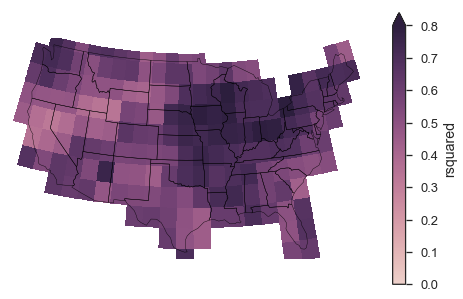

In [18]:
import seaborn as sns

ax = usa_states_ax(facecolor='None')
model.get_result_stat('rsquared')['rsquared'].plot.imshow(
    ax=ax, transform=ccrs.PlateCarree(), vmin=0., vmax=0.8, cmap=sns.cubehelix_palette(as_cmap=True))

model.get_result_stat('rsquared')['rsquared'].max()

In [35]:
from air_quality.models.shen2017 import _detrend_moving_avg, _normalize, _isin, _months_surrounding

# 1) The test dataset. Need to transform/untransform here
_to_model = data_test.copy()

# 2) The training dataset processed through the model. DO NOT transform/untransform. Note that
# . the detrending kills the last 2 years of data, so be careful when choosing a year to plot
# _to_model = model._data_detrend.copy()

# 3) Test dataset - but culled from a detrended full dataset. You don't need to sub-select
# .  timesteps below if you use this.
# _to_model = data.copy()groupby('time.month').apply(_detrend_moving_avg)
# _to_model = _to_model.isel(time=[-24-month-1, -12-month-1])

comp = _to_model.copy()
_to_model = _to_model.sel(time=_to_model['time.month'] == month)

_to_model = model.transform(_to_model)
comp = _to_model.copy()
result = model.predict(_to_model)
# result = model.untransform(result)

Iterate over grid cell models: 100%|██████████| 288/288 [00:05<00:00, 49.62it/s]


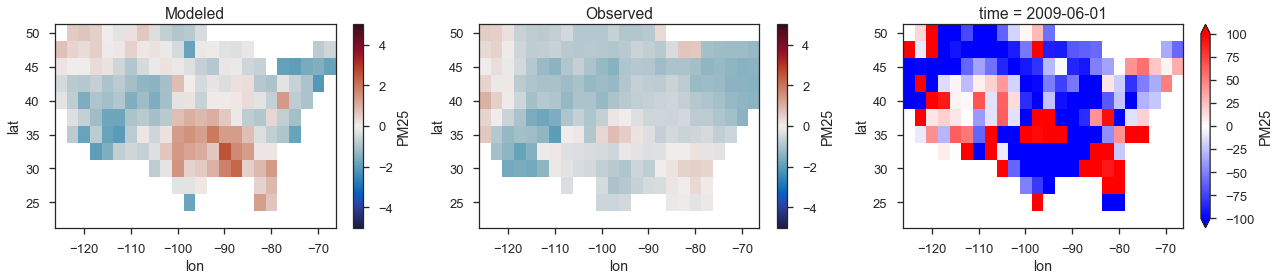

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(18., 4))
ax1, ax2, ax3 = axs.ravel()
cmap_kws = dict(
#     vmin=0, vmax=20, cmap=cmocean.cm.deep
    vmin=-5, vmax=5, cmap=cmocean.cm.balance
    
)

ts = "{}/{:02d}/01".format(2009, month)
result.sel(time=ts)['PM25'].plot.imshow(ax=ax1, **cmap_kws)
ax1.set_title('Modeled')
comp.sel(time=ts)['PM25'].plot.imshow(ax=ax2, **cmap_kws)
ax2.set_title('Observed')

(100*(result - comp)/comp).sel(time=ts)['PM25'].plot.imshow(ax=ax3,
    vmin=-100, vmax=100, cmap='bwr', center =0
)
plt.tight_layout()

From testing the original dataset...

38.3 -85.76
42 -71.0
32.5 -82.5


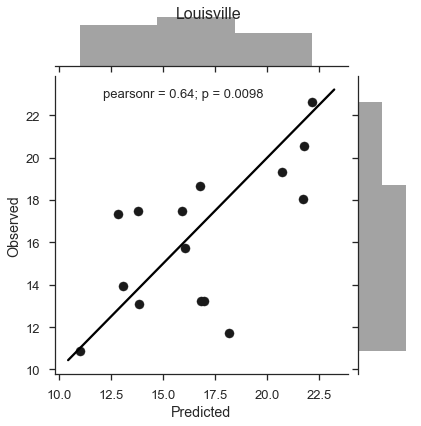

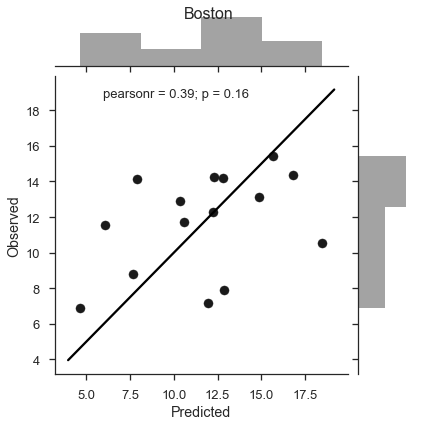

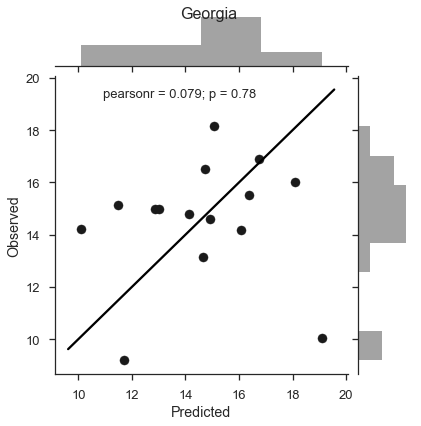

In [27]:
from air_quality.models.shen2017 import sites
import seaborn as sns

for _, site in sites.items():
    plt.figure()
    print(site.lat, site.lon)

    y_df = (
        comp
        .copy()
        .sel(lat=site.lat, lon=site.lon, method='nearest')
        .to_dataframe()
    )
    x_df = result.sel(lat=site.lat, lon=site.lon, method='nearest').to_dataframe()
    try:
        g = sns.jointplot(x_df['PM25'], y_df['PM25'], kind='scatter', color='0.1')
    except:
        continue
    ylo, yhi = g.ax_joint.get_ylim()
    xlo, xhi = g.ax_joint.get_xlim()
    lo = min([xlo, yhi])
    hi = max([xhi, yhi])
    g.ax_joint.plot([lo, hi], [lo, hi], color='k')
#     g.ax_joint.set_xlim(lo, hi)
#     g.ax_joint.set_ylim(lo, hi)
    g.set_axis_labels('Predicted', 'Observed')
    g.fig.suptitle(site.name, fontsize=16)

In [ ]:
for gcr, gcf in model._gcr_gcf_iter:
    if (gcr is not None) and (gcf.ilat == 4) and (gcf.ilon == 17):
        break

In [ ]:
ax = usa_states_ax(facecolor='None')
x = gcr.svd_modes.unstack('cell')['svd_weights'].sel(mode=1)
x.plot.imshow(ax=ax, transform=ccrs.PlateCarree())

In [ ]:
ax = usa_states_ax(facecolor='None')
x = gcr.pt_corrs.unstack('cell')['TEMP_r']
x.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), vmin=-1., vmax=1, cmap='RdBu_r')
y = gcr.pt_corrs.unstack('cell')['TEMP_p']
y = y.where(y < 0.05)
y = y.to_dataframe().dropna().reset_index()
y.plot('lon', 'lat', kind='scatter', ax=ax, color='k', transform=ccrs.PlateCarree())

In [ ]:
ilon, ilat = gcf.ilon, gcf.ilat
x = model._data_detrend_months_normalize.isel(lon=ilon, lat=ilat).to_dataframe()
x.drop(['month', 'lat', 'lon',], axis=1).plot(subplots=True, layout=[3,2])

---

## CESM/CAM-Chem

In [50]:
from air_quality.models.shen2017 import Shen2017Model

grid_stack = ['lat', 'lon']
cell_name = 'cell'
predictand = 'PM25'
predictors = ['TEMP', 'RH', 'PRECIP', 'U', 'V']
dlon, dlat = 16, 10
dilon, dilat = 6, 4

data2 = xr.open_dataset("../data/processed/lu_2017/fgm.all_cases.usa_subset.nc")
data2 = data2.isel(lat=slice(0,-3))
data2.lon.values = data.lon.values
data_train = data2.sel(ic=3, pol='REF', dec='1980-2010').squeeze()
data_test = data2.sel(ic=1, pol='REF', dec='1980-2010').squeeze()

month = 7
# model = Shen2017Model(
#     data_train, month=7, verbose=True, n_predictors=7,
#     lat_range=(33, 43), lon_range=(-95, -75)
# )

In [20]:
# model.fit_parallel(4)

Loop over all grid cells: 100%|██████████| 360/360 [01:04<00:00,  5.58it/s]


Time elapsed =  7.935766000000001


Iterate over grid cell models: 100%|██████████| 360/360 [00:00<00:00, 392602.56it/s]


<xarray.DataArray 'mse_resid' ()>
array(19.707017517899313)
Coordinates:
    dec      <U9 '1980-2010'
    lev      float64 992.6
    ic       int64 3
    pol      <U3 'REF'
    cs       int64 30

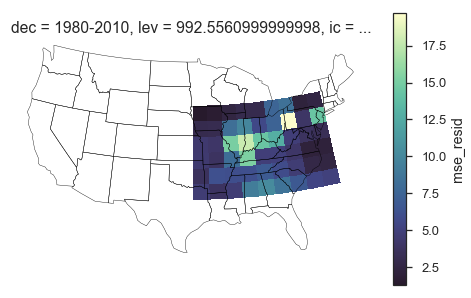

In [21]:
ax = usa_states_ax(facecolor='None')
model.get_result_stat('mse_resid')['mse_resid'].plot.imshow(
    ax=ax, transform=ccrs.PlateCarree(), cmap=cmocean.cm.deep_r)

model.get_result_stat('mse_resid')['mse_resid'].max()

In [51]:
from air_quality.models.shen2017 import _detrend_moving_avg, _normalize, _isin, _months_surrounding

# 1) The test dataset. Need to transform/untransform here
_to_model = data_train.copy().load()

# 2) The training dataset processed through the model. DO NOT transform/untransform. Note that
# . the detrending kills the last 2 years of data, so be careful when choosing a year to plot
# _to_model = model._data_detrend.copy()

# 3) Test dataset - but culled from a detrended full dataset. You don't need to sub-select
# .  timesteps below if you use this.
# _to_model = data.copy().groupby('time.month').apply(_detrend_moving_avg)
# _to_model = _to_model.isel(time=[-24-month-1, -12-month-1])

comp = _to_model.copy()
_to_model = _to_model.sel(time=_to_model['time.month'] == month)

_to_model = model.transform(_to_model)
# _to_model, _m, _s = _normalize(_to_model, return_all=True)
comp = _to_model.copy()
result = model.predict(_to_model)
# result = model.untransform(result)

Iterate over grid cell models:   0%|          | 0/288 [00:00<?, ?it/s]


IndexError: index 7 is out of bounds for axis 0 with size 0

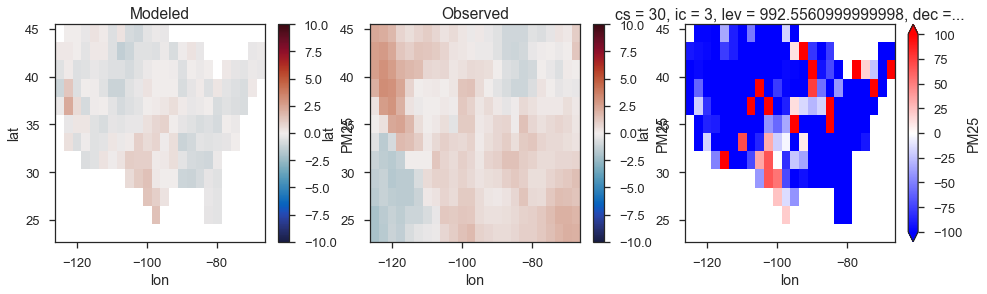

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(16., 4))
ax1, ax2, ax3 = axs.ravel()
cmap_kws = dict(
    vmin=-10, vmax=10,
    cmap=cmocean.cm.balance
)

ts = "{}/{:02d}/01".format(1985, month)
result.sel(time=ts)['PM25'].plot.imshow(ax=ax1, **cmap_kws)
ax1.set_title('Modeled')
comp.sel(time=ts)['PM25'].plot.imshow(ax=ax2, **cmap_kws)
ax2.set_title('Observed')

(100*(result - comp)/comp).sel(time=ts)['PM25'].plot.imshow(ax=ax3,
    vmin=-100, vmax=100, cmap='bwr', center =0
)

32.5 -82.5
42 -71.0
38.3 -85.76


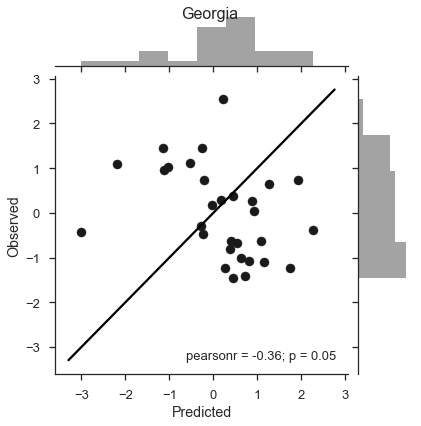

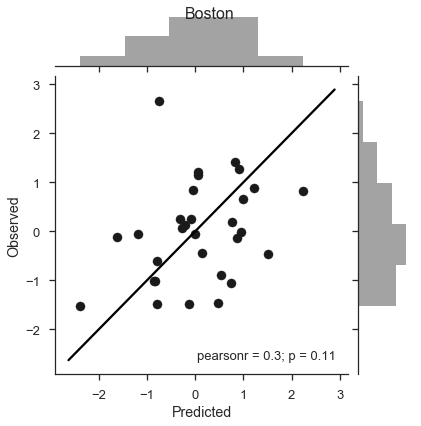

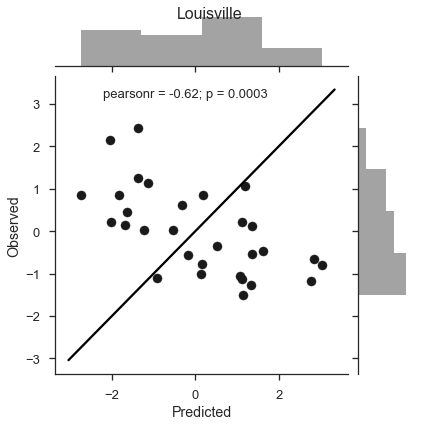

In [45]:
from air_quality.models.shen2017 import sites
import seaborn as sns

for _, site in sites.items():
    plt.figure()
    print(site.lat, site.lon)

    y_df = (
        comp
        .copy()
        .sel(lat=site.lat, lon=site.lon, method='nearest')
        .to_dataframe()
    )
    x_df = result.sel(lat=site.lat, lon=site.lon, method='nearest').to_dataframe()
    try:
        g = sns.jointplot(x_df['PM25'], y_df['PM25'], kind='scatter', color='0.1')
    except:
        continue
    ylo, yhi = g.ax_joint.get_ylim()
    xlo, xhi = g.ax_joint.get_xlim()
    lo = min([xlo, yhi])
    hi = max([xhi, yhi])
    g.ax_joint.plot([lo, hi], [lo, hi], color='k')
#     g.ax_joint.set_xlim(lo, hi)
#     g.ax_joint.set_ylim(lo, hi)
    g.set_axis_labels('Predicted', 'Observed')
    g.fig.suptitle(site.name, fontsize=16)

See what is going on under the hood...

In [30]:
for gcr, gcf in model._gcr_gcf_iter:
    if (gcr is not None):
        break
        
res = gcr.result
res.rsquared

Iterate over grid cell models:   0%|          | 0/360 [00:00<?, ?it/s]


0.28223966980087922

## CMIP5

# Detrending alternatives

In [ ]:
data = xr.open_dataset("../data/processed/lu_2017/obs.usa_subset.nc")
site = sites['Georgia']
ts = (
    data
    .sel(lon=site.lon, lat=site.lat, method='nearest')
    .to_dataframe()
    .drop(['lon', 'lat'], axis=1)
)

In [ ]:
from scipy.signal import detrend

def _mov_avg(ts):
    return ts - ts.rolling(5, center=True, min_periods=0).mean()

def _month_plot(site='Georgia', month=7):
    plt.clf()
    
    site = sites[site]
    
    ts = (
        data
            .sel(lon=site.lon, lat=site.lat, method='nearest')
            .to_dataframe()
            .drop(['lon', 'lat'], axis=1)
    )
    fig, axs = plt.subplots(3, 2, sharex=True, figsize=(12, 8))
    axs = axs.ravel()

    ts_month = ts.loc[ts.index.month == month]
    means = ts_month.mean()
    ts_month_dt_lin = ts_month.apply(detrend, type='linear') + means
    ts_month_dt_mov = ts_month.apply(_mov_avg) + means

    for ax, col in zip(axs, ts_month.columns):
        ts_month_dt_lin[col].plot(ax=ax, color='r', label='linear detrend')
        ts_month_dt_mov[col].plot(ax=ax, color='b', label='moving average')
        ts_month[col].plot(ax=ax, color='k', label='original')
        ax.set_ylabel(col)

    axs[0].legend(ncol=3, loc='lower left', bbox_to_anchor=(0., 1.05))
    plt.show()
    
    return fig

In [ ]:
fig = _month_plot()
fig.savefig("../figs/lu_2017/detrend_example.png", transparent=True)

In [ ]:
from ipywidgets import interact

interact(_month_plot, site=list(sites.keys()), month=range(1, 13))